In [3]:
import json

result_json = "/wkspace/sva_toolkit/experiments/benchmark_models/result.json"
hard_samples = set()
llm_list = ["deepseek-v3-1-250821", "claude-opus-4-5-20251101", "qwen3-coder-plus"]

with open(result_json, "r") as f:
    result_json = json.load(f)
    for llm in llm_list:
        for sample in result_json['sva_pairs_by_model'][llm]:
            if sample["relationship"] not in ["error", "equivalent"]:
                sample.pop("SVA2")
                sample.pop("relationship")
                sample["SVA"] = sample.pop("SVA1")
                hard_samples.add(json.dumps(sample))
                

In [1]:
"""
Test code to verify SVA relationships using LLM API.
This verifies if the relationship declared by EBMC is correct or if there are mismatches.
"""
import json
import sys
from pathlib import Path
from typing import Dict, Any, List, Optional
from sva_toolkit.utils.llm_client import LLMClient, LLMConfig

# Load LLM config
LLM_CONFIG_FILE = "/wkspace/sva_toolkit/examples/llm_configs.json"
RESULT_JSON_FILE = "/wkspace/sva_toolkit/experiments/benchmark_models/result.json"

# System prompt for LLM verification
VERIFICATION_SYSTEM_PROMPT = """You are an expert in SystemVerilog Assertions (SVA) and formal verification.
Your task is to analyze two SVA properties and determine their relationship:
- "equivalent": Both properties are logically equivalent (bidirectional implication)
- "sva1_implies_sva2": SVA1 implies SVA2 (SVA1 is stronger)
- "sva2_implies_sva1": SVA2 implies SVA1 (SVA2 is stronger)
- "no_relationship": No implication relationship exists in either direction

Consider:
- Logical equivalence (same behavior under all conditions)
- Temporal relationships (cycle delays, sequences)
- Disable conditions
- Clock domains
- Signal dependencies

Respond with ONLY one of: equivalent, sva1_implies_sva2, sva2_implies_sva1, no_relationship"""

VERIFICATION_USER_PROMPT_TEMPLATE = """Analyze the relationship between these two SVA properties:

SVA1:
{sva1}

SVA2:
{sva2}

Determine their relationship. Respond with ONLY one word: equivalent, sva1_implies_sva2, sva2_implies_sva1, or no_relationship."""

def load_llm_config(config_file: str) -> Dict[str, Any]:
    """Load LLM configuration from JSON file."""
    with open(config_file, 'r') as f:
        configs = json.load(f)
    # Use the first config (or you can specify which one to use)
    return configs[2]

def create_llm_client(config: Dict[str, Any]) -> LLMClient:
    """Create LLM client from configuration."""
    llm_config = LLMConfig(
        base_url=config['base_url'],
        model=config['model'],
        api_key=config['api_key'],
        temperature=0.1,  # Low temperature for consistent verification
        max_tokens=2000  # Short response expected
    )
    return LLMClient(llm_config)

def normalize_relationship(llm_response: str) -> str:
    """Normalize LLM response to standard relationship format."""
    response_lower = llm_response.strip().lower()
    # Map various possible responses to standard format
    if 'equivalent' in response_lower:
        return 'equivalent'
    elif 'sva1_implies_sva2' in response_lower or 'sva1 implies sva2' in response_lower:
        return 'sva1_implies_sva2'
    elif 'sva2_implies_sva1' in response_lower or 'sva2 implies sva1' in response_lower:
        return 'sva2_implies_sva1'
    elif 'no_relationship' in response_lower or 'no relationship' in response_lower:
        return 'no_relationship'
    else:
        return 'unknown'

def map_ebmc_relationship_to_llm_format(ebmc_relationship: str) -> str:
    """Map EBMC relationship format to LLM verification format."""
    mapping = {
        'equivalent': 'equivalent',
        'generated_implies_reference': 'sva2_implies_sva1',  # Assuming SVA1 is generated
        'reference_implies_generated': 'sva1_implies_sva2',  # Assuming SVA2 is reference
        'no_relationship': 'no_relationship',
        'error': 'error'
    }
    return mapping.get(ebmc_relationship, 'unknown')

def verify_sva_relationship(
    llm_client: LLMClient,
    sva1: str,
    sva2: str
) -> str:
    """Verify SVA relationship using LLM."""
    prompt = VERIFICATION_USER_PROMPT_TEMPLATE.format(sva1=sva1, sva2=sva2)
    try:
        response = llm_client.generate(
            prompt=prompt,
            system_prompt=VERIFICATION_SYSTEM_PROMPT,
            temperature=0.1
        )
        return normalize_relationship(response)
    except Exception as e:
        print(f"Error calling LLM: {e}")
        return 'error'

def test_relationships(
    result_file: str,
    llm_config_file: str,
    model_name: Optional[str] = None,
    max_samples: Optional[int] = None
) -> Dict[str, Any]:
    """Test SVA relationships using LLM verification."""
    # Load data
    with open(result_file, 'r') as f:
        results = json.load(f)
    llm_config = load_llm_config(llm_config_file)
    llm_client = create_llm_client(llm_config)
    # Process samples
    mismatches = []
    matches = []
    errors = []
    total_processed = 0
    # Determine which models to process
    models_to_process = [model_name] if model_name else list(results.get('sva_pairs_by_model', {}).keys())
    should_stop = False
    for model in models_to_process:
        if should_stop:
            break
        if model not in results.get('sva_pairs_by_model', {}):
            print(f"Warning: Model '{model}' not found in results")
            continue
        samples = results['sva_pairs_by_model'][model]
        for idx, sample in enumerate(samples):
            # Check if we've reached the max_samples limit
            if max_samples and total_processed >= max_samples:
                should_stop = True
                break
            total_processed += 1
            sva1 = sample.get('SVA1', '')
            sva2 = sample.get('SVA2', '')
            declared_relationship = sample.get('relationship', 'unknown')
            if not sva1 or not sva2:
                errors.append({
                    'model': model,
                    'index': idx,
                    'error': 'Missing SVA1 or SVA2'
                })
                continue
            if declared_relationship == 'error':
                errors.append({
                    'model': model,
                    'index': idx,
                    'error': 'EBMC reported error',
                    'sva1': sva1[:100] + '...' if len(sva1) > 100 else sva1,
                    'sva2': sva2[:100] + '...' if len(sva2) > 100 else sva2
                })
                continue
            if declared_relationship == 'equivalent':
                continue
            # Verify using LLM
            llm_relationship = verify_sva_relationship(llm_client, sva1, sva2)
            declared_normalized = map_ebmc_relationship_to_llm_format(declared_relationship)
            # Compare
            if llm_relationship == 'error':
                errors.append({
                    'model': model,
                    'index': idx,
                    'error': 'LLM verification error',
                    'declared': declared_relationship
                })
            elif llm_relationship == declared_normalized:
                matches.append({
                    'model': model,
                    'index': idx,
                    'relationship': declared_relationship
                })
            else:
                mismatches.append({
                    'model': model,
                    'index': idx,
                    'declared_relationship': declared_relationship,
                    'llm_relationship': llm_relationship,
                    'sva1': sva1[:200] + '...' if len(sva1) > 200 else sva1,
                    'sva2': sva2[:200] + '...' if len(sva2) > 200 else sva2
                })
            # Progress indicator
            if total_processed % 10 == 0:
                print(f"Processed {total_processed} samples...")
    # Summary
    summary = {
        'total_processed': total_processed,
        'matches_count': len(matches),
        'mismatches_count': len(mismatches),
        'errors_count': len(errors),
        'match_rate': len(matches) / total_processed if total_processed > 0 else 0,
        'mismatch_rate': len(mismatches) / total_processed if total_processed > 0 else 0,
        'matches': matches,
        'mismatches': mismatches,
        'errors': errors
    }
    return summary

# Example usage
if __name__ == "__main__":
    print("Starting SVA relationship verification test...")
    print(f"Loading results from: {RESULT_JSON_FILE}")
    print(f"Using LLM config from: {LLM_CONFIG_FILE}")
    summary = test_relationships(
        result_file=RESULT_JSON_FILE,
        llm_config_file=LLM_CONFIG_FILE,
        model_name="deepseek-v3-1-250821",  # Set to specific model name or None for all models
        max_samples=None  # Set to None to process all samples, or a number for testing
    )
    print("\n" + "="*60)
    print("VERIFICATION SUMMARY")
    print("="*60)
    print(f"Total processed: {summary['total_processed']}")
    print(f"Matches: {summary['matches_count']} ({summary['match_rate']*100:.2f}%)")
    print(f"Mismatches: {summary['mismatches_count']} ({summary['mismatch_rate']*100:.2f}%)")
    print(f"Errors: {summary['errors_count']}")
    # Save results to file
    output_file = "/wkspace/sva_toolkit/experiments/benchmark_models/llm_verification_results.json"
    with open(output_file, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"\nResults saved to: {output_file}")
    if summary['mismatches_count'] > 0:
        print("\n" + "="*60)
        print("MISMATCHES FOUND (EBMC vs LLM):")
        print("="*60)
        for mismatch in summary['mismatches'][:5]:  # Show first 5
            print(f"\nModel: {mismatch['model']}, Index: {mismatch['index']}")
            print(f"EBMC says: {mismatch['declared_relationship']}")
            print(f"LLM says: {mismatch['llm_relationship']}")
            print(f"SVA1: {mismatch['sva1'][:150]}...")
            print(f"SVA2: {mismatch['sva2'][:150]}...")

Starting SVA relationship verification test...
Loading results from: /wkspace/sva_toolkit/experiments/benchmark_models/result.json
Using LLM config from: /wkspace/sva_toolkit/examples/llm_configs.json
Processed 30 samples...
Processed 40 samples...
Processed 50 samples...
Processed 60 samples...
Processed 120 samples...
Processed 160 samples...
Processed 180 samples...
Processed 190 samples...
Processed 200 samples...
Processed 210 samples...
Processed 230 samples...
Processed 250 samples...
Processed 290 samples...
Processed 320 samples...

VERIFICATION SUMMARY
Total processed: 325
Matches: 41 (12.62%)
Mismatches: 57 (17.54%)
Errors: 1

Results saved to: /wkspace/sva_toolkit/experiments/benchmark_models/llm_verification_results.json

MISMATCHES FOUND (EBMC vs LLM):

Model: deepseek-v3-1-250821, Index: 5
EBMC says: no_relationship
LLM says: equivalent
SVA1: property p_subtra_shift_assignment;
    @(posedge clk) disable iff (rst == 1)
        (rst == 0 && enable == 1) |-> ##1 subtra_shi

In [ ]:
# Run the verification test
# Adjust parameters as needed:
# - model_name: specific model to test, or None for all models
# - max_samples: number of samples to test, or None for all

print("Starting SVA relationship verification test...")
print(f"Loading results from: {RESULT_JSON_FILE}")
print(f"Using LLM config from: {LLM_CONFIG_FILE}")

summary = test_relationships(
    result_file=RESULT_JSON_FILE,
    llm_config_file=LLM_CONFIG_FILE,
    model_name=None,  # Set to specific model name (e.g., "deepseek-v3-1-250821") or None for all models
    max_samples=10  # Set to None to process all samples, or a number for testing
)

print("\n" + "="*60)
print("VERIFICATION SUMMARY")
print("="*60)
print(f"Total processed: {summary['total_processed']}")
print(f"Matches: {summary['matches_count']} ({summary['match_rate']*100:.2f}%)")
print(f"Mismatches: {summary['mismatches_count']} ({summary['mismatch_rate']*100:.2f}%)")
print(f"Errors: {summary['errors_count']}")

# Save results to file
output_file = "/wkspace/sva_toolkit/experiments/benchmark_models/llm_verification_results.json"
with open(output_file, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"\nResults saved to: {output_file}")

# Display mismatches
if summary['mismatches_count'] > 0:
    print("\n" + "="*60)
    print("MISMATCHES FOUND (EBMC vs LLM):")
    print("="*60)
    for i, mismatch in enumerate(summary['mismatches'][:10], 1):  # Show first 10
        print(f"\n[{i}] Model: {mismatch['model']}, Index: {mismatch['index']}")
        print(f"    EBMC says: {mismatch['declared_relationship']}")
        print(f"    LLM says: {mismatch['llm_relationship']}")
        print(f"    SVA1: {mismatch['sva1'][:150]}...")
        print(f"    SVA2: {mismatch['sva2'][:150]}...")

In [12]:
with open("/wkspace/sva_toolkit/experiments/benchmark_models/hard_dataset.json", "w") as f:
    f.write(json.dumps(list(json.loads(s) for s in hard_samples), indent=2))

In [ ]:
raw_dataset = "/wkspace/sva_toolkit/examples/eda/aug_svas_predict_1204.jsonl"
preprocessed_dataset = "/wkspace/sva_toolkit/examples/eda/aug_svas_predict_1204.jsonl"

preprocessed_data = []
with open(raw_dataset, "r") as f:
    for line in f:
        item = json.loads(f)
        try:
            preprocessed_data.append({
                "id": item['id'],
                "sva1": item['ori_sva'],
                "sva2": item['full_property']
                })
        except:
            print(f"Error processing item {item['id']}")

with open(preprocessed_dataset, "w") as f:
    json.dump(preprocessed_data, f, indent=4)

print(f"Preprocessed {len(preprocessed_data)} SVA properties")

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load results
result_json_path = "/wkspace/sva_toolkit/experiments/benchmark_models/result.json"
with open(result_json_path, 'r') as f:
    data = json.load(f)

comparison = data['comparison']
results = data['results']

print("Data loaded successfully!")
print(f"Number of models: {len(comparison['models'])}")


Data loaded successfully!
Number of models: 4


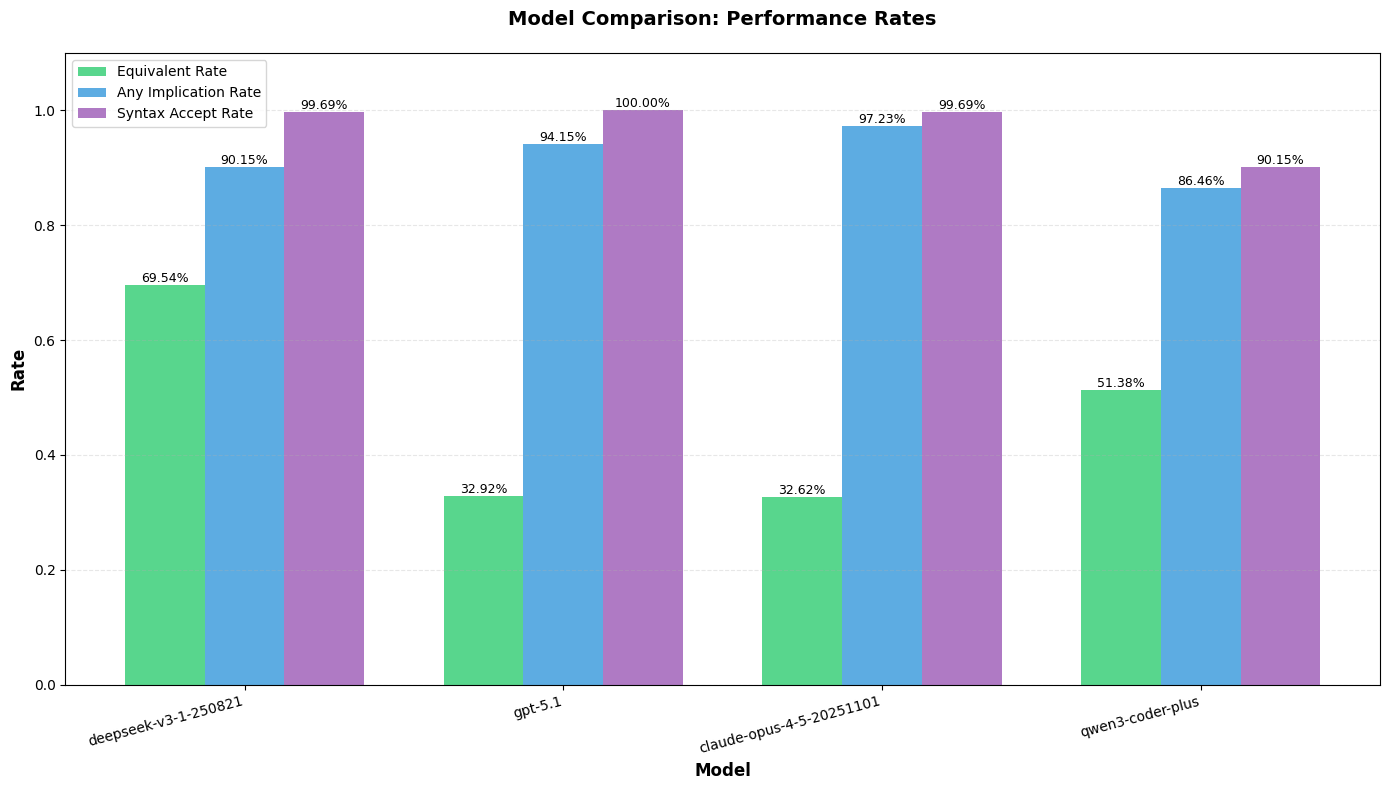

In [4]:
# Plot 1: Comparison Summary - Rates across all models
models = comparison['models']
equivalent_rates = comparison['equivalent_rates']
any_implication_rates = comparison['any_implication_rates']
success_rates = comparison['success_rates']

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.bar(x - width, equivalent_rates, width, label='Equivalent Rate', color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x, any_implication_rates, width, label='Any Implication Rate', color='#3498db', alpha=0.8)
bars3 = ax.bar(x + width, success_rates, width, label='Syntax Accept Rate', color='#9b59b6', alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Rate', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison: Performance Rates', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.set_ylim([0, 1.1])
ax.legend(loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2%}',
               ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


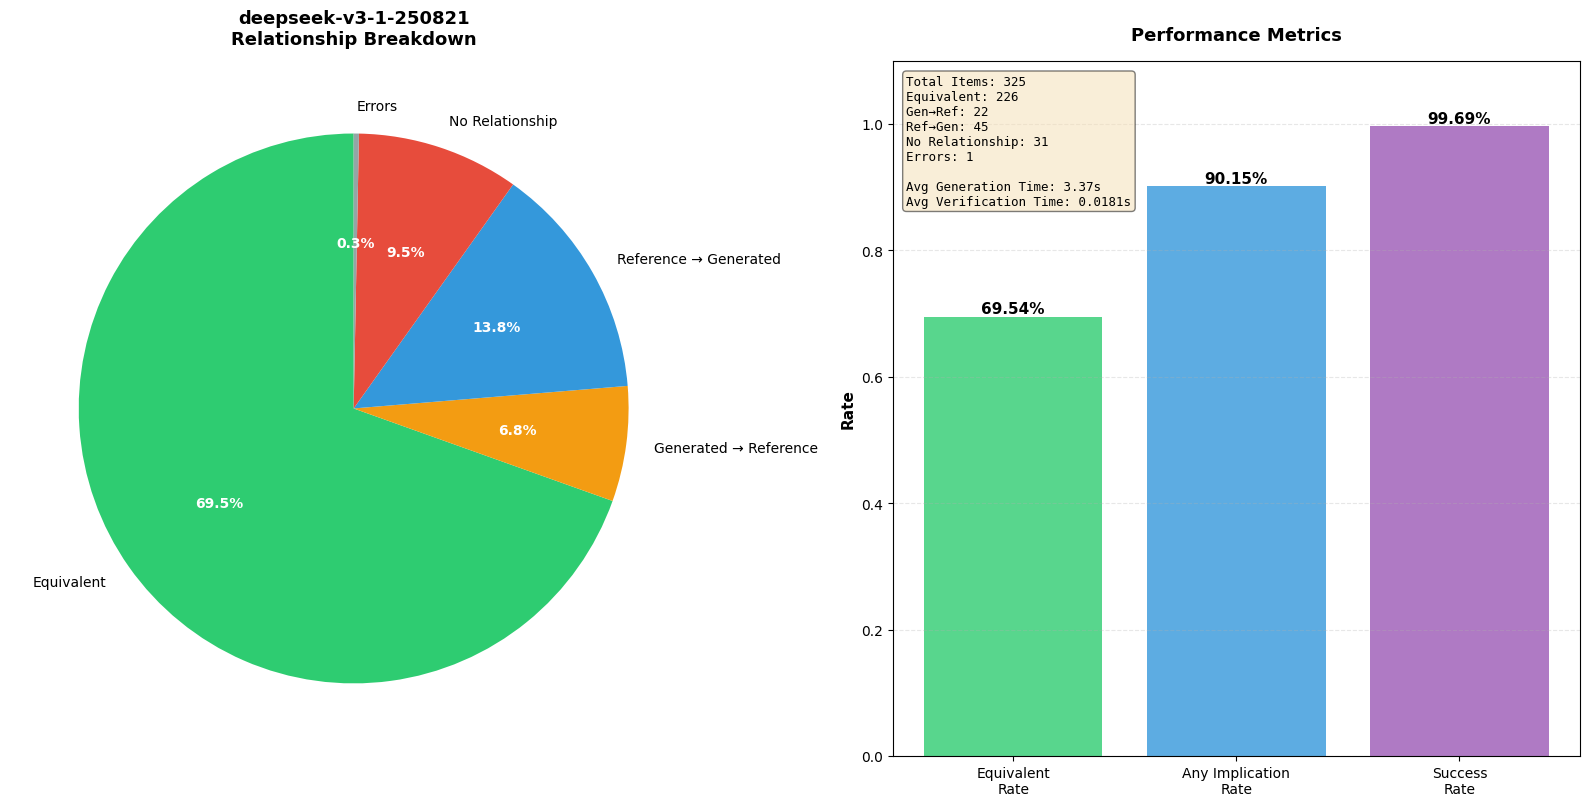

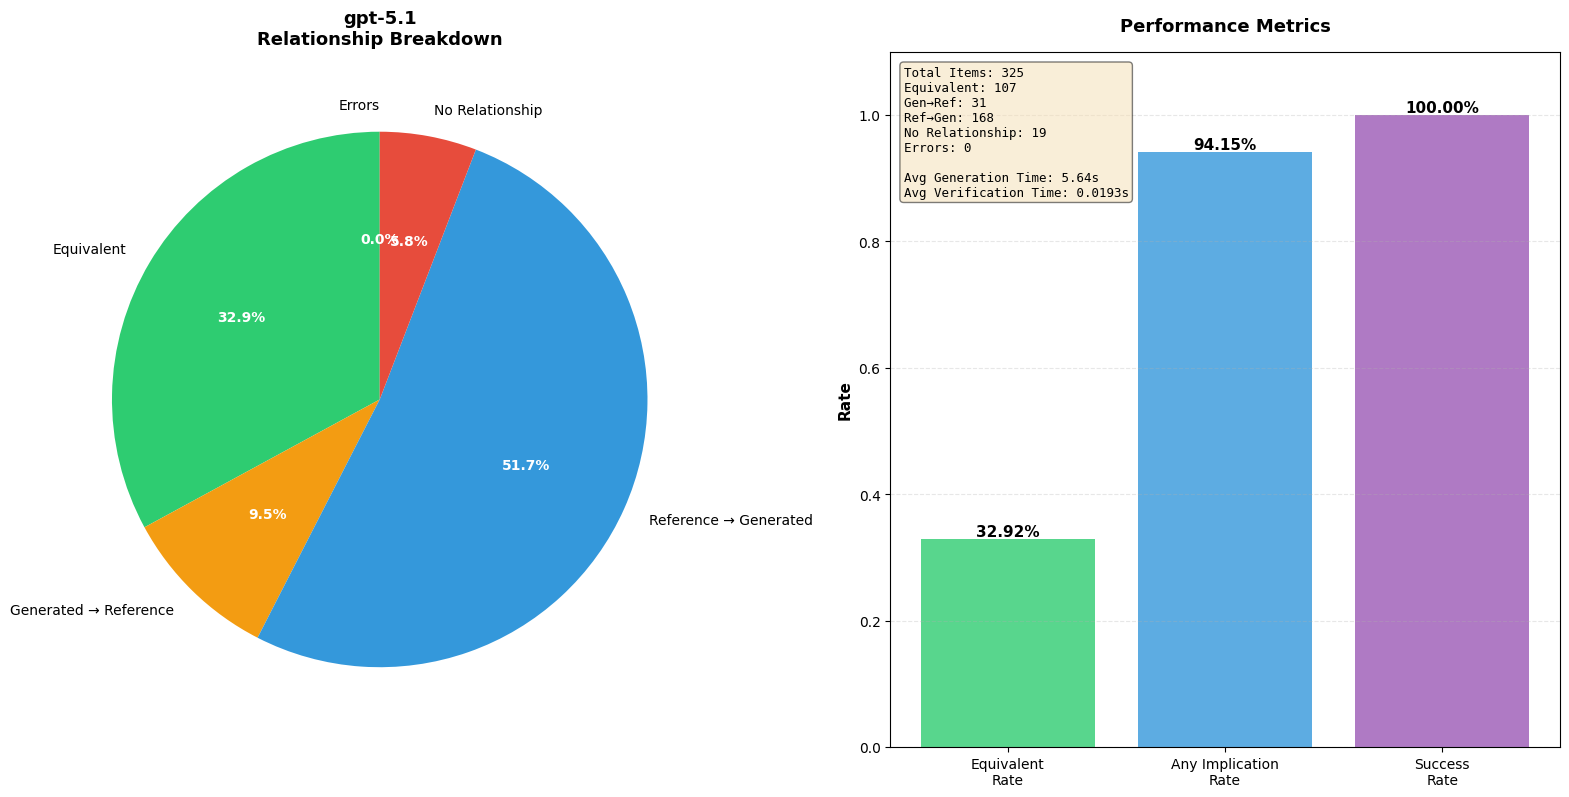

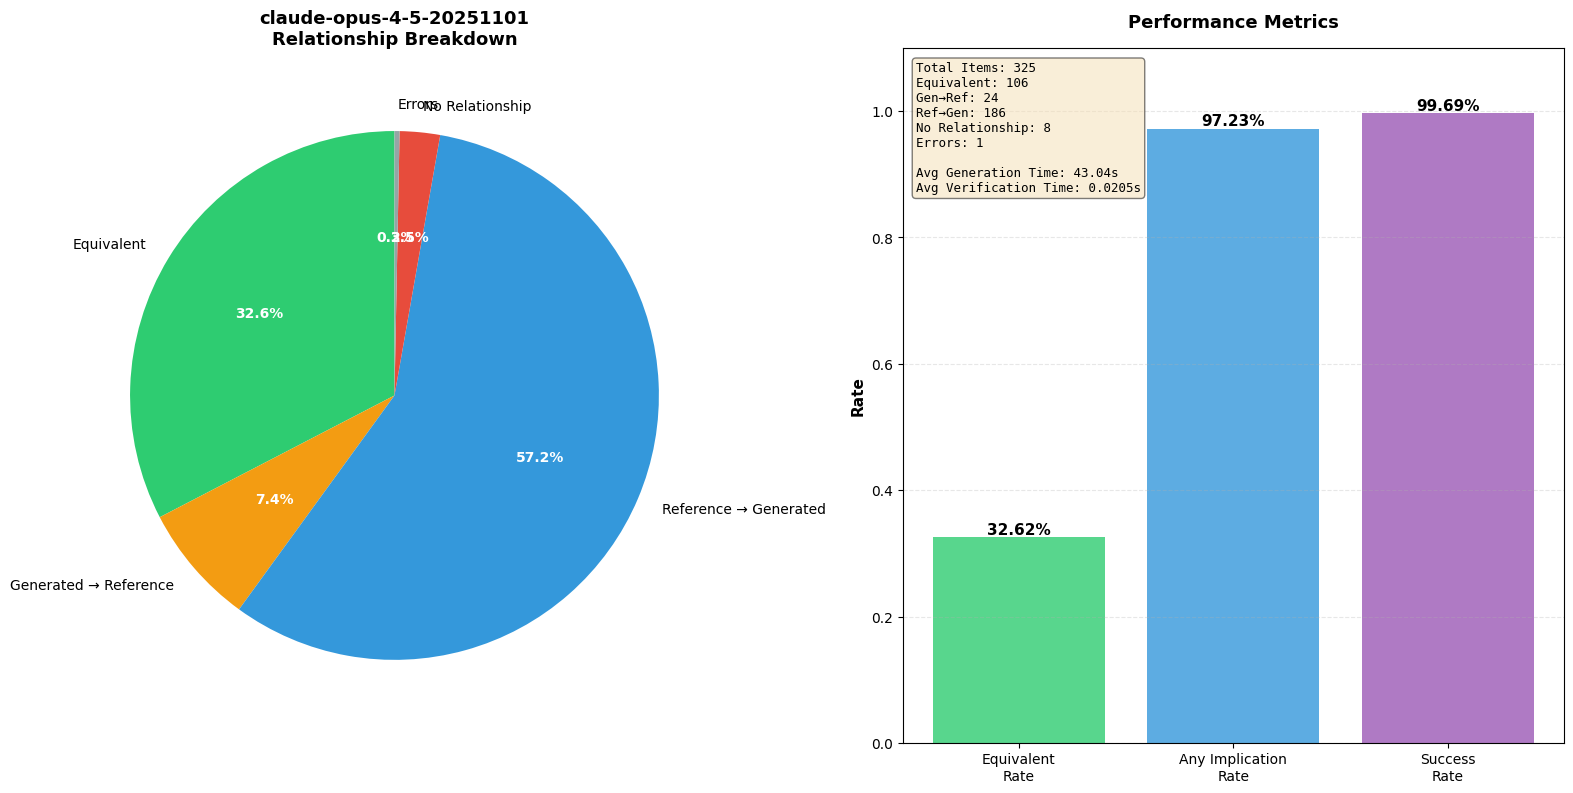

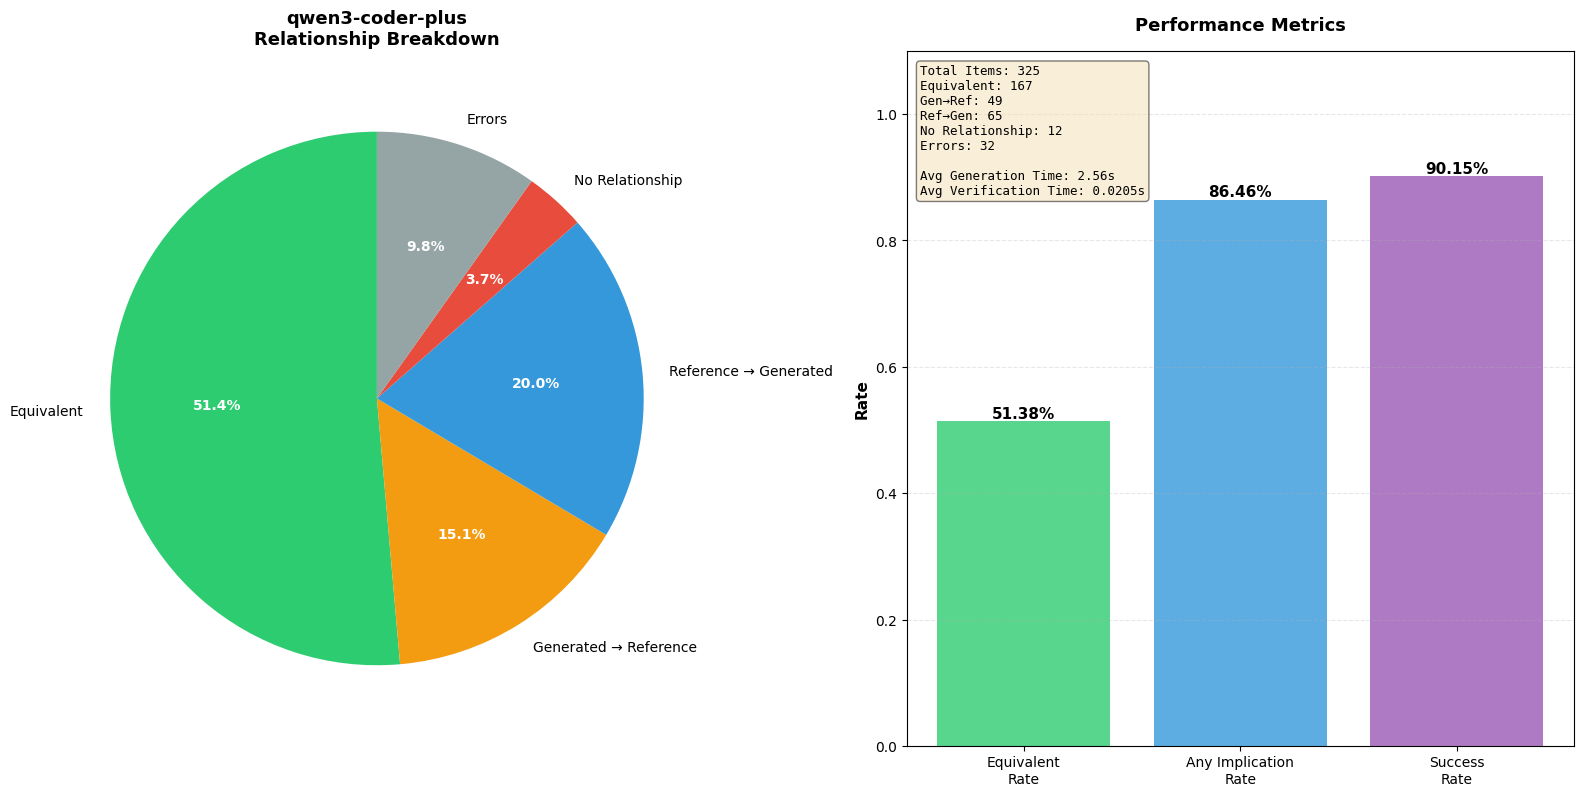

In [5]:
# Plot 2: Individual Model Breakdowns
def plot_model_breakdown(result):
    """Plot detailed breakdown for a single model."""
    model_name = result['model_name']
    total = result['total_items']
    
    # Prepare data for pie chart
    labels = [
        'Equivalent',
        'Generated → Reference',
        'Reference → Generated',
        'No Relationship',
        'Errors'
    ]
    sizes = [
        result['equivalent_count'],
        result['generated_implies_reference_count'],
        result['reference_implies_generated_count'],
        result['no_relationship_count'],
        result['error_count']
    ]
    colors = ['#2ecc71', '#f39c12', '#3498db', '#e74c3c', '#95a5a6']
    
    # Create figure with two subplots
    fig = plt.figure(figsize=(16, 8))
    
    # Pie chart
    ax1 = plt.subplot(1, 2, 1)
    wedges, texts, autotexts = ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                                        startangle=90, textprops={'fontsize': 10})
    ax1.set_title(f'{model_name}\nRelationship Breakdown', fontsize=13, fontweight='bold', pad=15)
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # Bar chart with metrics
    ax2 = plt.subplot(1, 2, 2)
    metrics = ['Equivalent\nRate', 'Any Implication\nRate', 'Success\nRate']
    values = [
        result['equivalent_rate'],
        result['any_implication_rate'],
        result['success_rate']
    ]
    bars = ax2.bar(metrics, values, color=['#2ecc71', '#3498db', '#9b59b6'], alpha=0.8)
    ax2.set_ylabel('Rate', fontsize=11, fontweight='bold')
    ax2.set_title('Performance Metrics', fontsize=13, fontweight='bold', pad=15)
    ax2.set_ylim([0, 1.1])
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add text box with detailed counts
    textstr = f"""Total Items: {total}
Equivalent: {result['equivalent_count']}
Gen→Ref: {result['generated_implies_reference_count']}
Ref→Gen: {result['reference_implies_generated_count']}
No Relationship: {result['no_relationship_count']}
Errors: {result['error_count']}

Avg Generation Time: {result['avg_generation_time']:.2f}s
Avg Verification Time: {result['avg_verification_time']:.4f}s"""
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.02, 0.98, textstr, transform=ax2.transAxes, fontsize=9,
            verticalalignment='top', bbox=props, family='monospace')
    
    plt.tight_layout()
    plt.show()

# Plot breakdown for each model
for result in results:
    plot_model_breakdown(result)


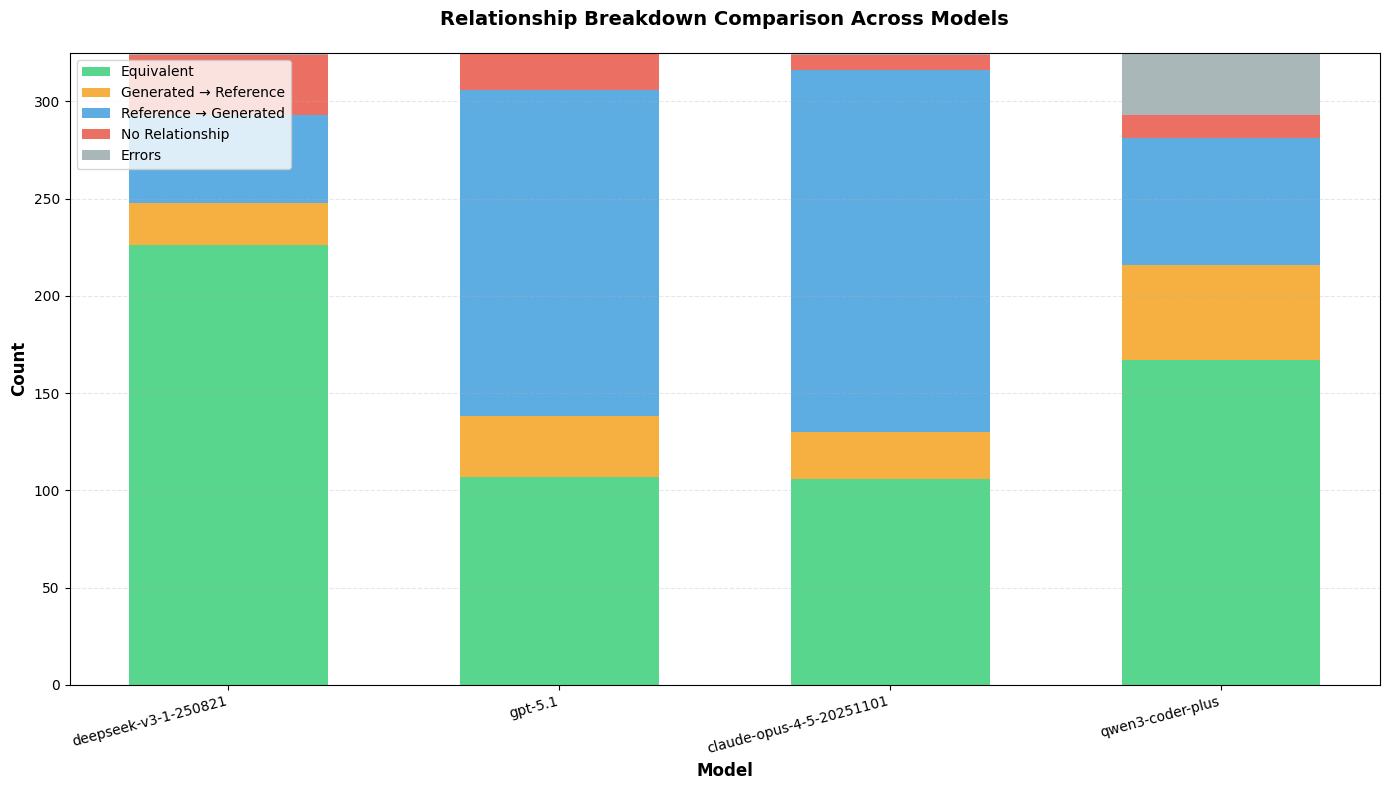

In [6]:
# Plot 3: Relationship Breakdown Comparison Across All Models
models = [r['model_name'] for r in results]
n_models = len(models)

# Prepare data
equivalent = [r['equivalent_count'] for r in results]
gen_to_ref = [r['generated_implies_reference_count'] for r in results]
ref_to_gen = [r['reference_implies_generated_count'] for r in results]
no_rel = [r['no_relationship_count'] for r in results]
errors = [r['error_count'] for r in results]

x = np.arange(n_models)
width = 0.6

fig, ax = plt.subplots(figsize=(14, 8))

# Stacked bar chart
p1 = ax.bar(x, equivalent, width, label='Equivalent', color='#2ecc71', alpha=0.8)
p2 = ax.bar(x, gen_to_ref, width, bottom=equivalent, label='Generated → Reference', color='#f39c12', alpha=0.8)
p3 = ax.bar(x, ref_to_gen, width, bottom=np.array(equivalent) + np.array(gen_to_ref),
            label='Reference → Generated', color='#3498db', alpha=0.8)
p4 = ax.bar(x, no_rel, width,
            bottom=np.array(equivalent) + np.array(gen_to_ref) + np.array(ref_to_gen),
            label='No Relationship', color='#e74c3c', alpha=0.8)
p5 = ax.bar(x, errors, width,
            bottom=np.array(equivalent) + np.array(gen_to_ref) + np.array(ref_to_gen) + np.array(no_rel),
            label='Errors', color='#95a5a6', alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Relationship Breakdown Comparison Across Models', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


# Iterative Generation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data 1: Model Comparison
models_data = {
    "models": ["deepseek-v3-1-250821", "gpt-5.1", "claude-opus-4-5-20251101", "qwen3-coder-plus"],
    "equivalent_rates": [0.24923076923076923, 0.15692307692307692, 0.24307692307692308, 0.10153846153846154],
    "any_implication_rates": [0.9538461538461539, 0.9292307692307692, 0.9692307692307692, 0.6615384615384615],
    "result_count": [
        {"equivalent_count": 81, "generated_implies_reference_count": 22, "reference_implies_generated_count": 207, "no_relationship_count": 13, "error_count": 2},
        {"equivalent_count": 51, "generated_implies_reference_count": 48, "reference_implies_generated_count": 203, "no_relationship_count": 19, "error_count": 4},
        {"equivalent_count": 79, "generated_implies_reference_count": 29, "reference_implies_generated_count": 207, "no_relationship_count": 9, "error_count": 1},
        {"equivalent_count": 33, "generated_implies_reference_count": 25, "reference_implies_generated_count": 157, "no_relationship_count": 12, "error_count": 98}
    ]
}

df_models = pd.DataFrame(models_data)
counts_df_models = pd.DataFrame(models_data["result_count"])
df_models = pd.concat([df_models, counts_df_models], axis=1).drop(columns=['result_count'])

# Data 2: Deepseek Prompt Variants
deepseek_data = {
    "Prompt": ["iterative_basic", "iterative_critique", "iterative_refinement"],
    "equivalent_rates": [0.8276923076923077, 0.8153846153846154, 0.7353846153846154],
    "any_implication_rates": [0.9538461538461539, 0.9661538461538461, 0.963076923076923],
    "result_count": [
        {"equivalent_count": 269, "generated_implies_reference_count": 24, "reference_implies_generated_count": 24, "no_relationship_count": 6, "error_count": 2},
        {"equivalent_count": 265, "generated_implies_reference_count": 26, "reference_implies_generated_count": 23, "no_relationship_count": 10, "error_count": 1},
        {"equivalent_count": 239, "generated_implies_reference_count": 27, "reference_implies_generated_count": 47, "no_relationship_count": 11, "error_count": 1}
    ]
}
df_deepseek = pd.DataFrame(deepseek_data)
counts_df_deepseek = pd.DataFrame(deepseek_data["result_count"])
df_deepseek = pd.concat([df_deepseek, counts_df_deepseek], axis=1).drop(columns=['result_count'])
df_deepseek['Model'] = 'deepseek-v3-1-250821'

# Data 3: GPT-5.1 Prompt Variants
gpt51_data = {
    "Prompt": ["iterative_basic", "iterative_critique", "iterative_refinement"],
    "equivalent_rates": [0.3476923076923077, 0.3230769230769231, 0.24],
    "any_implication_rates": [0.9723076923076923, 0.9784615384615385, 0.9661538461538461],
    "result_count": [
        {"equivalent_count": 113, "generated_implies_reference_count": 44, "reference_implies_generated_count": 159, "no_relationship_count": 7, "error_count": 2},
        {"equivalent_count": 105, "generated_implies_reference_count": 61, "reference_implies_generated_count": 152, "no_relationship_count": 6, "error_count": 1},
        {"equivalent_count": 78, "generated_implies_reference_count": 43, "reference_implies_generated_count": 193, "no_relationship_count": 9, "error_count": 2}
    ]
}
df_gpt51 = pd.DataFrame(gpt51_data)
counts_df_gpt51 = pd.DataFrame(gpt51_data["result_count"])
df_gpt51 = pd.concat([df_gpt51, counts_df_gpt51], axis=1).drop(columns=['result_count'])
df_gpt51['Model'] = 'gpt-5.1'

# Combine prompt variants data for the specific visualization
df_combined_prompts = pd.concat([df_deepseek, df_gpt51], ignore_index=True)

# -----------------
# Plot 1: Model Comparison - Rates
# -----------------
fig, ax1 = plt.subplots(figsize=(10, 6))

models = df_models['models']
x = np.arange(len(models))
width = 0.35

rects1 = ax1.bar(x - width/2, df_models['equivalent_rates'], width, label='Equivalent Rate (Dual Implication)')
rects2 = ax1.bar(x + width/2, df_models['any_implication_rates'], width, label='Any Implication Rate')

# Add some text for labels, titles and custom x-axis tick labels, etc.
ax1.set_ylabel('Rate', fontsize=12)
ax1.set_title('Model Comparison: Equivalence and Implication Rates', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha="right")
ax1.legend(loc='upper left')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('model_comparison_rates.png')
plt.close()


# -----------------
# Plot 2: Model Comparison - Counts (Stacked Bar Chart)
# -----------------
categories = ['equivalent_count', 'generated_implies_reference_count', 'reference_implies_generated_count', 'no_relationship_count', 'error_count']
labels = ['Equivalent', 'Generated $\\Rightarrow$ Reference (Pulling Back)', 'Reference $\\Rightarrow$ Generated (Pushing Out)', 'No Relationship', 'Error']
colors = ['#4daf4a', '#377eb8', '#e41a1c', '#ff7f00', '#984ea3']

fig, ax = plt.subplots(figsize=(12, 7))

bottom = np.zeros(len(df_models))

for i, cat in enumerate(categories):
    counts = df_models[cat]
    ax.bar(df_models['models'], counts, bottom=bottom, label=labels[i], color=colors[i])
    bottom += counts

ax.set_ylabel('Count (Total $N=325$)', fontsize=12)
ax.set_title('Model Comparison: Relationship Counts', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(df_models['models'], rotation=45, ha="right")
ax.legend(title="Relationship Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('model_comparison_counts.png')
plt.close()

# -----------------
# Plot 3: Deepseek Prompt Variants - Rates
# -----------------
# Rates
fig, ax1 = plt.subplots(figsize=(8, 6))
prompts = df_deepseek['Prompt']
x = np.arange(len(prompts))
width = 0.35

rects1 = ax1.bar(x - width/2, df_deepseek['equivalent_rates'], width, label='Equivalent Rate (Dual Implication)')
rects2 = ax1.bar(x + width/2, df_deepseek['any_implication_rates'], width, label='Any Implication Rate')

ax1.set_ylabel('Rate', fontsize=12)
ax1.set_title('Deepseek Prompt Variants: Equivalence and Implication Rates', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(prompts, rotation=0)
ax1.legend(loc='upper right')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('deepseek_prompts_rates.png')
plt.close()

# -----------------
# Plot 4: Deepseek Prompt Variants - Counts (Stacked Bar)
# -----------------
fig, ax = plt.subplots(figsize=(10, 7))
bottom = np.zeros(len(df_deepseek))

for i, cat in enumerate(categories):
    counts = df_deepseek[cat]
    ax.bar(df_deepseek['Prompt'], counts, bottom=bottom, label=labels[i], color=colors[i])
    bottom += counts

ax.set_ylabel('Count (Total $N=325$)', fontsize=12)
ax.set_title('Deepseek Prompt Variants: Relationship Counts', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(df_deepseek['Prompt'], rotation=0)
ax.legend(title="Relationship Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('deepseek_prompts_counts.png')
plt.close()

# -----------------
# Plot 5: GPT-5.1 Prompt Variants - Rates
# -----------------
# Rates
fig, ax1 = plt.subplots(figsize=(8, 6))
prompts = df_gpt51['Prompt']
x = np.arange(len(prompts))
width = 0.35

rects1 = ax1.bar(x - width/2, df_gpt51['equivalent_rates'], width, label='Equivalent Rate (Dual Implication)')
rects2 = ax1.bar(x + width/2, df_gpt51['any_implication_rates'], width, label='Any Implication Rate')

ax1.set_ylabel('Rate', fontsize=12)
ax1.set_title('GPT-5.1 Prompt Variants: Equivalence and Implication Rates', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(prompts, rotation=0)
ax1.legend(loc='upper right')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('gpt51_prompts_rates.png')
plt.close()

# -----------------
# Plot 6: GPT-5.1 Prompt Variants - Counts (Stacked Bar)
# -----------------
fig, ax = plt.subplots(figsize=(10, 7))
bottom = np.zeros(len(df_gpt51))

for i, cat in enumerate(categories):
    counts = df_gpt51[cat]
    ax.bar(df_gpt51['Prompt'], counts, bottom=bottom, label=labels[i], color=colors[i])
    bottom += counts

ax.set_ylabel('Count (Total $N=325$)', fontsize=12)
ax.set_title('GPT-5.1 Prompt Variants: Relationship Counts', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(df_gpt51['Prompt'], rotation=0)
ax.legend(title="Relationship Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('gpt51_prompts_counts.png')
plt.close()

# -----------------
# Plot 7: Specific Visualization - Equivalent, Pushing Out, Pulling Back
# -----------------

# Define the three key count columns
key_counts = ['equivalent_count', 'reference_implies_generated_count', 'generated_implies_reference_count']
key_labels = ['Equivalent', 'Pushing Out (Ref $\\Rightarrow$ Gen)', 'Pulling Back (Gen $\\Rightarrow$ Ref)']
key_colors = ['#4daf4a', '#e41a1c', '#377eb8']

df_plot7 = df_combined_prompts.copy()
df_plot7['Group'] = df_plot7['Model'] + ' - ' + df_plot7['Prompt']

fig, ax = plt.subplots(figsize=(14, 8))

# Set the positions for the groups
groups = df_plot7['Group'].unique()
x = np.arange(len(groups))
width = 0.25  # Width of each bar

# Plot bars for each key count
for i, count_col in enumerate(key_counts):
    # Calculate the positions for the bars of this category
    bar_positions = x + (i - 1) * width
    ax.bar(bar_positions, df_plot7[count_col], width, label=key_labels[i], color=key_colors[i])

# Add labels, title, and legend
ax.set_ylabel('Count (Total $N=325$)', fontsize=12)
ax.set_title('Comparison of Implication Counts Across Models and Prompt Variants', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha="right")
ax.legend(title="Relationship Type", loc='upper left')
ax.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('prompt_variant_key_counts.png')
plt.close()